## Preprocess data

In [1]:
cd ..

/home/compute/APS-360


In [2]:
import torch
import torch.nn as nn
import pandas as pd
from common import model
from common import evaluate
from common import separate_test
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from ann import *

In [3]:
def day_to_num(day):
    ls = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'other']
    if day != 0:
        return ls.index(day) + 1
    return 0

def time_to_num(time):
    if time == 0:
        return 0
    time = time.replace(':', '')
    return float(time)

In [4]:
df_data = pd.read_csv('balanced_animes_data_max_rank=5000.csv')
df_data = df_data.fillna(0)
df_data['broadcast_day_of_the_week'] = df_data['broadcast_day_of_the_week'].apply(day_to_num)
df_data['broadcast_start_time'] = df_data['broadcast_start_time'].apply(time_to_num)

test_ids = open(f'common/test_ids.txt', 'r').read()
test_ids = test_ids.strip('[]')
test_ids = test_ids.split(', ')
test_ids = [int(t) for t in test_ids]

if 'id' not in df_data.columns:
    raise Exception("dataframe needs to have an 'id' column")

df_test = df_data[df_data['id'].isin(test_ids)]
df_data_new = df_data[~(df_data['id'].isin(test_ids))]
df_test = df_test.drop(labels=['id', 'unique_id'], axis=1)
df_data_new = df_data_new.drop(labels=['id', 'unique_id'], axis=1)

In [5]:
df_test = df_test.fillna(0)
df_data_new = df_data_new.fillna(0)

keep = ['popularity', 'broadcast_day_of_the_week', 'average_episode_duration', 'broadcast_start_time']
for d in df_test.columns:
    if 'id' in d:
        keep.append(d)

df_test = df_test[keep]
df_data_new = df_data_new[keep]

In [6]:
df_test.to_csv('test_data')
df_data_new.to_csv('train_val_data')

In [7]:
df_test.columns

Index(['popularity', 'broadcast_day_of_the_week', 'average_episode_duration',
       'broadcast_start_time', 'genres_0_id', 'genres_1_id', 'genres_2_id',
       'genres_3_id', 'genres_4_id', 'genres_5_id', 'genres_6_id',
       'genres_7_id', 'studios_0_id', 'studios_1_id', 'studios_2_id',
       'genres_8_id', 'genres_9_id', 'genres_10_id', 'studios_3_id',
       'studios_4_id', 'studios_5_id'],
      dtype='object')

In [16]:
df_data.groupby('studios_0_name').count()

,unique_id,id,title,main_picture_medium,main_picture_large,start_date,end_date,synopsis,mean,rank,...,genres_9_id,genres_9_name,genres_10_id,genres_10_name,studios_3_id,studios_3_name,studios_4_id,studios_4_name,studios_5_id,studios_5_name
studios_0_name,,,,,,,,,,,,,,,,,,,,,
8bit,44,44,44,44,44,44,44,44,44,44,...,44,44,44,44,44,44,44,44,44,44
A-1 Pictures,134,134,134,134,134,134,134,134,134,134,...,134,134,134,134,134,134,134,134,134,134
A.C.G.T.,20,20,20,20,20,20,20,20,20,20,...,20,20,20,20,20,20,20,20,20,20
AIC,52,52,52,52,52,52,52,52,52,52,...,52,52,52,52,52,52,52,52,52,52
AIC ASTA,15,15,15,15,15,15,15,15,15,15,...,15,15,15,15,15,15,15,15,15,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
lxtl,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
production doA,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
studio MOTHER,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [10]:
len(df_data_new.columns)

21

## Train Model

In [1]:
cd ..

/home/compute/APS-360


In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import pandas as pd
from common import model
from common import evaluate
from common import separate_test
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from ann import *

In [3]:
dataset='train_val_data'
test_dataset = 'test_data'

### Tune # of Layers

In [4]:
#READY TO RUN
#This function allows us to loop through the data to train on three different NUMBER OF LAYERS
for l in [4, 8, 16]:
    ann = ANN('ANNl', 64, 0.01, 75, l, 32, F.relu)
    ann.to('cuda')
    train, val = get_data_loaders(dataset, ann.batch_size)
    model.train_model(ann, train, val)

/home/compute/APS-360/ann/ann.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data = torch.tensor(row[2:]).float()
/home/compute/APS-360/ann/ann.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data = torch.tensor(row[2:]).float()
/home/compute/APS-360/ann/ann.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data = torch.tensor(row[2:]).float()


### Tune hidden_size

In [5]:
#READY TO RUN
#This function allows us to loop through the data to train on three different NUMBER OF LAYERS
for h in [16, 32, 64]:
    ann = ANN('ANNh', 64, 0.01, 75, 8, h, F.relu)
    ann.to('cuda')
    train, val = get_data_loaders(dataset, ann.batch_size)
    model.train_model(ann, train, val)

/home/compute/APS-360/ann/ann.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data = torch.tensor(row[2:]).float()
/home/compute/APS-360/ann/ann.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data = torch.tensor(row[2:]).float()
/home/compute/APS-360/ann/ann.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data = torch.tensor(row[2:]).float()


### Tune activation func

In [6]:
#READY TO RUN
#This function allows us to loop through the data to train on three different NUMBER OF LAYERS
for f in [F.relu, F.tanh, F.hardswish]:
    ann = ANN('ANNf', 64, 0.01, 75, 8, 32, f)
    ann.to('cuda')
    train, val = get_data_loaders(dataset, ann.batch_size)
    model.train_model(ann, train, val)

/home/compute/APS-360/ann/ann.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data = torch.tensor(row[2:]).float()
/home/compute/APS-360/ann/ann.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data = torch.tensor(row[2:]).float()
/home/compute/APS-360/ann/ann.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data = torch.tensor(row[2:]).float()


### Tune activation batch_size

In [7]:
#READY TO RUN
#This function allows us to loop through the data to train on three different NUMBER OF LAYERS
for b in [32, 64, 128]:
    ann = ANN('ANNb', b, 0.01, 75, 8, 32, F.relu)
    ann.to('cuda')
    train, val = get_data_loaders(dataset, ann.batch_size)
    model.train_model(ann, train, val)

/home/compute/APS-360/ann/ann.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data = torch.tensor(row[2:]).float()
/home/compute/APS-360/ann/ann.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data = torch.tensor(row[2:]).float()
/home/compute/APS-360/ann/ann.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data = torch.tensor(row[2:]).float()


### Tune activation lr

In [8]:
#READY TO RUN
#This function allows us to loop through the data to train on three different NUMBER OF LAYERS
for lr in [0.01, 0.05, 0.1]:
    ann = ANN('ANNlr', 64, lr, 75, 8, 32, F.relu)
    ann.to('cuda')
    train, val = get_data_loaders(dataset, ann.batch_size)
    model.train_model(ann, train, val)

/home/compute/APS-360/ann/ann.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data = torch.tensor(row[2:]).float()
/home/compute/APS-360/ann/ann.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data = torch.tensor(row[2:]).float()
/home/compute/APS-360/ann/ann.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data = torch.tensor(row[2:]).float()


In [4]:
evaluate.get_best_loss('ANN')

[0.2456844631341071, 71, 'training/ANNf_64_0.01_75_8_32_hardswish_74_val_loss.csv']


[0.2456844631341071,
 71,
 'training/ANNf_64_0.01_75_8_32_hardswish_74_val_loss.csv']

## Train best model for another 30 epochs

In [3]:
net = ANN('anneval', 64, 0.01, 30, 8, 32, F.hardswish)
model_path = 'training/ANNf_64_0.01_75_8_32_hardswish_71'
state = torch.load(model_path)
net.load_state_dict(state)

torch.manual_seed(0)
train, val = get_data_loaders('train_val_data', 64)
net.to('cuda')
model.train_model(net, train, val)

/home/compute/APS-360/ann/ann.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data = torch.tensor(row[2:]).float()


## Evaluate

In [1]:
cd ..

/home/compute/APS-360


In [2]:
import torch
import torch.nn as nn
import pandas as pd
from common import model
from common import evaluate
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

from ann import *

from glob import glob
import numpy as np
import math

In [3]:
train, val = get_data_loaders('train_val_data', 64)
test = get_data_loaders('test_data', 64)

In [24]:
model = ANN('anneval', 64, 0.01, 75, 8, 32, F.hardswish)
model_path = 'training/ANNf_64_0.01_75_8_32_hardswish_71'
state = torch.load(model_path)
model.load_state_dict(state)

<All keys matched successfully>

In [7]:
torch.manual_seed(0)
evaluate.evaluate(model, train), evaluate.evaluate(model, val), evaluate.evaluate(model, test)

(0.23126714993172323, 0.22238007349939354, 0.28535890855209944)

/home/compute/APS-360/ann/ann.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data = torch.tensor(row[2:]).float()


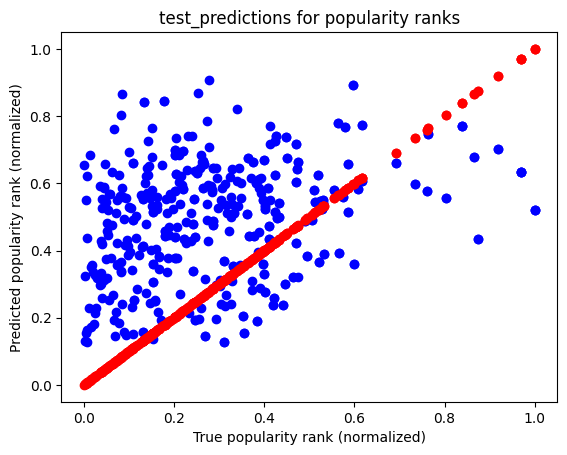

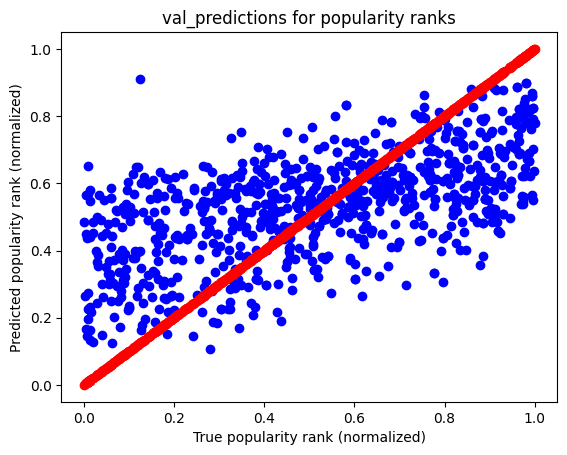

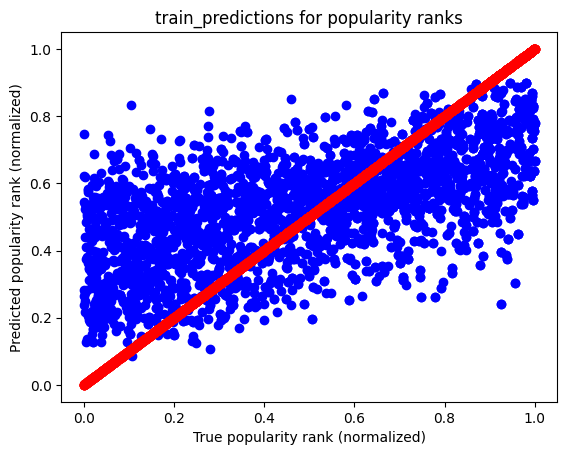

In [9]:
preds = []
labels_list = []

train, val = get_data_loaders('train_val_data', 1)
test = get_data_loaders('test_data', 1)

for i, data in enumerate(test, 0):
    inputs, labels = data
    pred = model(inputs)
    preds.append(pred.item())
    labels_list.append(labels.item())

import matplotlib.pyplot as plt
plt.figure(1)
plt.plot(labels_list, preds, 'bo')
plt.plot(labels_list, labels_list, 'ro')
# plt.xlim(0.00, 1.00)
# plt.ylim(-0.00, 1.00)
plt.title("test_predictions for popularity ranks")
plt.xlabel("True popularity rank (normalized)")
plt.ylabel("Predicted popularity rank (normalized)")
plt.savefig('ANN_test_plot')
plt.show()

preds = []
labels_list = []
for i, data in enumerate(val, 0):
    inputs, labels = data
    # print(inputs)
    # print(labels)
    pred = model(inputs)
    preds.append(pred.item())
    labels_list.append(labels.item())   
plt.figure(2)
plt.plot(labels_list, preds, 'bo')
plt.plot(labels_list, labels_list, 'ro')
# plt.xlim(0.00, 1.00)
# plt.ylim(-0.00, 1.00)
plt.title("val_predictions for popularity ranks")
plt.xlabel("True popularity rank (normalized)")
plt.ylabel("Predicted popularity rank (normalized)")
plt.savefig('ANN_val_plot')
plt.show()

preds = []
labels_list = []
for i, data in enumerate(train, 0):
    inputs, labels = data
    # print(inputs)
    # print(labels)
    pred = model(inputs)
    preds.append(pred.item())
    labels_list.append(labels.item())   
plt.figure(3)
plt.plot(labels_list, preds, 'bo')
plt.plot(labels_list, labels_list, 'ro')
# plt.xlim(0.00, 1.00)
# plt.ylim(-0.00, 1.00)
plt.title("train_predictions for popularity ranks")
plt.xlabel("True popularity rank (normalized)")
plt.ylabel("Predicted popularity rank (normalized)")
plt.savefig('ANN_train_plot')
plt.show()

In [3]:
def day_to_num(day):
    ls = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'other']
    if day != 0:
        return ls.index(day) + 1
    return 0

def time_to_num(time):
    if time == 0:
        return 0
    time = time.replace(':', '')
    return float(time)

In [20]:
# df_data = pd.read_csv('new_test_animes_data.csv')
# df_data = df_data.fillna(0)
df_data['broadcast_day_of_the_week'] = df_data['broadcast_day_of_the_week'].apply(day_to_num)
df_data['broadcast_start_time'] = df_data['broadcast_start_time'].apply(time_to_num)

# df_data= df_data.drop(labels=['id'], axis=1)

In [5]:
df_data = pd.read_csv('new_test_animes_data.csv')
df_data = df_data.fillna(0)
len(df_data.columns)

45

In [6]:
df_old = pd.read_csv('test_data')
for column in df_old.columns:
    if column not in df_data.columns:
        df_data[column] = 0

In [9]:
df_data = df_data.fillna(0)

keep = ['popularity', 'broadcast_day_of_the_week', 'average_episode_duration', 'broadcast_start_time']
for d in df_data.columns:
    if 'id' in d:
        keep.append(d)

df_data = df_data[keep]
df_data= df_data.drop(labels=['id'], axis=1)

In [10]:
df_old.columns

Index(['Unnamed: 0', 'popularity', 'broadcast_day_of_the_week',
       'average_episode_duration', 'broadcast_start_time', 'genres_0_id',
       'genres_1_id', 'genres_2_id', 'genres_3_id', 'genres_4_id',
       'genres_5_id', 'genres_6_id', 'genres_7_id', 'studios_0_id',
       'studios_1_id', 'studios_2_id', 'genres_8_id', 'genres_9_id',
       'genres_10_id', 'studios_3_id', 'studios_4_id', 'studios_5_id'],
      dtype='object')

In [11]:
df_data.columns

Index(['popularity', 'broadcast_day_of_the_week', 'average_episode_duration',
       'broadcast_start_time', 'genres_0_id', 'genres_1_id', 'genres_2_id',
       'genres_3_id', 'studios_0_id', 'genres_4_id', 'genres_5_id',
       'genres_6_id', 'genres_7_id', 'studios_1_id', 'studios_2_id',
       'genres_8_id', 'genres_9_id', 'genres_10_id', 'studios_3_id',
       'studios_4_id', 'studios_5_id'],
      dtype='object')

In [27]:
col_list = df_old.columns.to_list()[1:]
# df_data['Unnamed: 0'] = np.arange(len(df_data))
df_data = df_data[col_list]
df_data.columns

Index(['popularity', 'broadcast_day_of_the_week', 'average_episode_duration',
       'broadcast_start_time', 'genres_0_id', 'genres_1_id', 'genres_2_id',
       'genres_3_id', 'genres_4_id', 'genres_5_id', 'genres_6_id',
       'genres_7_id', 'studios_0_id', 'studios_1_id', 'studios_2_id',
       'genres_8_id', 'genres_9_id', 'genres_10_id', 'studios_3_id',
       'studios_4_id', 'studios_5_id'],
      dtype='object')

In [26]:
len(df_data.columns)

22

In [29]:
df_data.to_csv('new_test_data')

In [28]:
for d in df_data.columns:
    print(d, df_data[d].dtype)

popularity int64
broadcast_day_of_the_week int64
average_episode_duration int64
broadcast_start_time float64
genres_0_id int64
genres_1_id float64
genres_2_id float64
genres_3_id float64
genres_4_id float64
genres_5_id float64
genres_6_id float64
genres_7_id float64
studios_0_id int64
studios_1_id float64
studios_2_id float64
genres_8_id int64
genres_9_id int64
genres_10_id int64
studios_3_id int64
studios_4_id int64
studios_5_id int64


In [30]:
test = get_data_loaders('new_test_data', 64)
evaluate.evaluate(model, test)

/home/compute/APS-360/ann/ann.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data = torch.tensor(row[2:]).float()


0.259762165505682